# Классификация типов пользователей Divvy Bike Sharing
## Сравнение Random Forest и XGBoost

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.filterwarnings('ignore')

In [46]:
# Загрузка данных и сэмплирование
df = pd.read_csv('../data/trips.csv', encoding="utf_16_le")
df = df.sample(frac=0.2, random_state=42)
print(df.shape)

(28975, 10)


In [47]:
# Предобработка данных
df['started_at'] = pd.to_datetime(df['started_at'])
df['ended_at'] = pd.to_datetime(df['ended_at'])
df['ride_duration'] = (df['ended_at'] - df['started_at']).dt.total_seconds()

# Очистка пустых значений
df = df.dropna(subset=['start_station_name', 'end_station_name', 'rideable_type', 'member_casual'])

# Целевая переменная
y = df['member_casual'].map({'member': 1, 'casual': 0})

# Признаки
X = df[['ride_duration', 'rideable_type', 'start_station_name', 'end_station_name']]

In [48]:
# Предобработка пайплайн
categorical_features = ['rideable_type', 'start_station_name', 'end_station_name']
numerical_features = ['ride_duration']

preprocessor = ColumnTransformer([
    ('num', SimpleImputer(strategy='median'), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

In [49]:
# Функция оценки модели
def evaluate_model(model, X_train, y_train, cv=5):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    acc_scores = []
    f1_scores = []
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)
        acc = accuracy_score(y_val, preds)
        f1 = f1_score(y_val, preds)
        acc_scores.append(acc)
        f1_scores.append(f1)
        print(f'Fold {fold+1}: Accuracy={acc:.4f}, F1={f1:.4f}')
    return acc_scores, f1_scores

In [50]:
# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Применение препроцессора
X_train_enc = preprocessor.fit_transform(X_train)
X_test_enc = preprocessor.transform(X_test)

In [51]:
# Модель 1: Random Forest
rf = RandomForestClassifier(random_state=42)
rf_acc, rf_f1 = evaluate_model(rf, X_train_enc, y_train)

Fold 1: Accuracy=0.8309, F1=0.9053
Fold 2: Accuracy=0.8317, F1=0.9056
Fold 3: Accuracy=0.8336, F1=0.9068
Fold 4: Accuracy=0.8300, F1=0.9049
Fold 5: Accuracy=0.8275, F1=0.9032


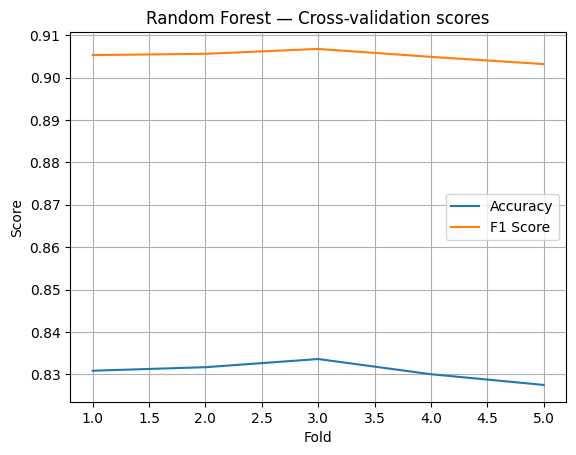

In [52]:
# Визуализация точности по фолдам
plt.plot(range(1, 6), rf_acc, label='Accuracy')
plt.plot(range(1, 6), rf_f1, label='F1 Score')
plt.title('Random Forest — Cross-validation scores')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

In [53]:
# Модель 2: XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_acc, xgb_f1 = evaluate_model(xgb, X_train_enc, y_train)

Fold 1: Accuracy=0.8433, F1=0.9144
Fold 2: Accuracy=0.8452, F1=0.9156
Fold 3: Accuracy=0.8449, F1=0.9155
Fold 4: Accuracy=0.8435, F1=0.9148
Fold 5: Accuracy=0.8443, F1=0.9150


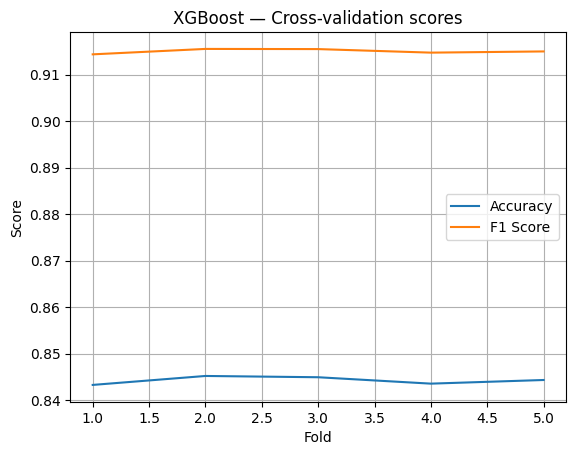

In [54]:
# Визуализация точности по фолдам
plt.plot(range(1, 6), xgb_acc, label='Accuracy')
plt.plot(range(1, 6), xgb_f1, label='F1 Score')
plt.title('XGBoost — Cross-validation scores')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

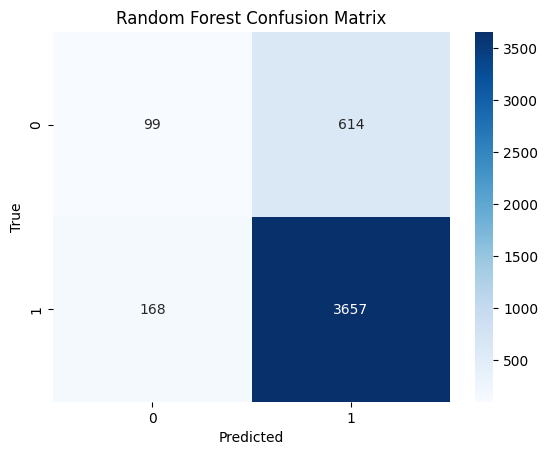

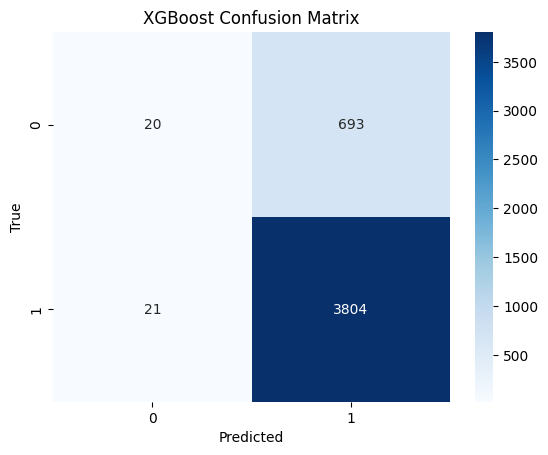

In [55]:
# Матрица ошибок
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_confusion_matrix(y_test, rf.predict(X_test_enc), 'Random Forest Confusion Matrix')
plot_confusion_matrix(y_test, xgb.predict(X_test_enc), 'XGBoost Confusion Matrix')

In [56]:
# Подбор гиперпараметров для Random Forest
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 5]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, scoring='accuracy', cv=3)
grid_search.fit(X_train_enc, y_train)

results = pd.DataFrame(grid_search.cv_results_)
print(results[['params', 'mean_test_score']])

                                     params  mean_test_score
0   {'max_depth': None, 'n_estimators': 50}         0.826216
1  {'max_depth': None, 'n_estimators': 100}         0.827704
2      {'max_depth': 5, 'n_estimators': 50}         0.842967
3     {'max_depth': 5, 'n_estimators': 100}         0.842967


In [57]:
# Подбор гиперпараметров для XGBoost
param_grid_xgb = {
    'learning_rate': [0.01, 0.1],
    'n_estimators': [50, 100]
}

grid_search_xgb = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss'), 
                              param_grid_xgb, scoring='accuracy', cv=3)
grid_search_xgb.fit(X_train_enc, y_train)

results_xgb = pd.DataFrame(grid_search_xgb.cv_results_)
print(results_xgb[['params', 'mean_test_score']])

                                         params  mean_test_score
0   {'learning_rate': 0.01, 'n_estimators': 50}         0.842967
1  {'learning_rate': 0.01, 'n_estimators': 100}         0.842967
2    {'learning_rate': 0.1, 'n_estimators': 50}         0.844344
3   {'learning_rate': 0.1, 'n_estimators': 100}         0.844675
